In [1]:
import numpy as np
import pandas as pd
from ipypb import track

from polara.evaluation import evaluation_engine as ee
from polara.evaluation.pipelines import find_optimal_svd_rank
from polara import (SVDModel,
                    PopularityModel,
                    RandomModel)
from polara.recommender.hybrid.models import SimilarityAggregation
from polara.recommender.coldstart.models import (SVDModelItemColdStart,
                                                 RandomModelItemColdStart,
                                                 PopularityModelItemColdStart,
                                                 SimilarityAggregationItemColdStart)

from data_preprocessing import (get_yahoo_music_data,
                                get_similarity_data,
                                prepare_data_model,
                                prepare_cold_start_data_model)
from utils import (report_results, save_results,
                   apply_config, print_data_stats,
                   save_training_time, save_cv_training_time)
%matplotlib inline

In [2]:
from polara.recommender import defaults
defaults.memory_hard_limit = 15 # allowed memory usage during recommendations generation
max_test_workers = 6 # use this manyparallel thread for evaluation each using up to {memory_hard_limit} Gb of RAM

In [3]:
seed = 42

In [4]:
experiment_name = 'baseline'

# Experiment setup

In [5]:
data_labels = ['YaMus']

In [6]:
ranks_grid = [1, 15, 30, 50, 75, 100, 150, 200, 250, 300, 400,
              500, 750, 1000, 1250, 1500, 2000, 2500, 3000]
svd_ranks = {'YaMus': ranks_grid}

In [7]:
topk_values = [1, 3, 10, 20, 30]

In [8]:
target_metric = 'mrr'

In [9]:
data_dict = dict.fromkeys(data_labels)
meta_dict = dict.fromkeys(data_labels)
similarities = dict.fromkeys(data_labels)
sim_indices = dict.fromkeys(data_labels)
feature_idx = dict.fromkeys(data_labels)

In [10]:
all_data = [data_dict, similarities, sim_indices, meta_dict]

## Yahoo Music

In [11]:
lbl = 'YaMus'

In [12]:
data_dict[lbl], meta_dict[lbl] = get_yahoo_music_data('/gpfs/gpfs0/e.frolov/recsys/yahoo_music/yamus_train0_rating5.gz',
                                                      meta_path='/gpfs/gpfs0/e.frolov/recsys/yahoo_music/yamus_attrs.gz',
                                                      implicit=True,
                                                      pcore=5,
                                                      filter_data={'genreid': [0]}, # filter unknown genre
                                                      filter_no_meta=True)

In [13]:
similarities[lbl], sim_indices[lbl], feature_idx[lbl] = get_similarity_data(meta_dict[lbl])

In [14]:
(meta_dict[lbl].applymap(len).sum(axis=1)==0).mean()

0.0

## Data stats

In [15]:
print_data_stats(data_labels, all_data)

YaMus
{'userid': 183003, 'songid': 134059}
density 0.09740952587383789
similarity matrix density 0.4576464914574314


# Standard experiment

In [16]:
def prepare_recommender_models(data_label, data_models, config):
    data_model = data_models[data_label]
    models = [SVDModel(data_model),
              SimilarityAggregation(data_model),
              PopularityModel(data_model),
              RandomModel(data_model, seed=seed)]
    for model in models:
        model.max_test_workers = max_test_workers
    apply_config(models, config, data_label)
    return models


def fine_tune_svd(model, ranks, label, record_time=False):
    model.max_test_workers = max_test_workers
    best_svd_rank, svd_scores = find_optimal_svd_rank(model, ranks, target_metric,
                                                      return_scores=True,
                                                      iterator=lambda x: track(x, label=f'{label} ranks'))
    model_config = {model.method: {'rank': best_svd_rank}}
    model_scores = {model.method: svd_scores}
    try:
        if record_time:
            save_training_time(experiment_name, model, pd.Index([max(ranks)], name='rank'), label)
    finally:
        return model_config, model_scores

## tuning

In [ ]:
config = {}
scores = {}
data_models = {}

In [ ]:
for label in track(data_labels):
    data_models[label] = prepare_data_model(label, *all_data, seed)
    config[label], scores[label] = fine_tune_svd(SVDModel(data_models[label]),
                                                 svd_ranks[label],
                                                 label, True)

 [████████████████████████████████████████████████████████████] 1/1 [03:33:05<03:33:05, 12784.51s/it]

    YaMus ranks [█████████████████████████████████████████████] 19/19 [36:52<01:21, 116.44s/it]

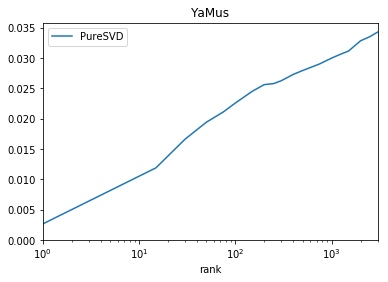

In [ ]:
report_results('rank', scores);

In [ ]:
config

{'YaMus': {'PureSVD': {'rank': 3000}}}

### saving data

In [ ]:
save_results(experiment_name, config=config, tuning=scores)

## cross-validation

In [25]:
result = {}

for label in track(data_labels):
    models = prepare_recommender_models(label, data_models, config)
    result[label] = ee.run_cv_experiment(models,
                                         fold_experiment=ee.topk_test,
                                         topk_list=topk_values,
                                         ignore_feedback=True,
                                         iterator=lambda x: track(x, label=f'{label} folds'))
    save_cv_training_time(experiment_name, models, label)

 [████████████████████████████████████████████████████████████] 1/1 [06:16:28<06:16:28, 22587.57s/it]

    YaMus folds [█████████████████████████████████████████████] 5/5 [06:16:28<01:15:24, 4517.51s/it]

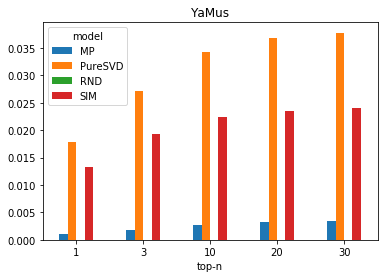

In [26]:
report_results('topn', result, target_metric);

### saving data

In [27]:
save_results(experiment_name, cv=result)

# Cold start

In [28]:
def prepare_cold_start_recommender_models(data_label, data_models, config):
    data_model = data_models[data_label]
    models = [SVDModelItemColdStart(data_model, item_features=meta_dict[data_label]),
              SimilarityAggregationItemColdStart(data_model),
              PopularityModelItemColdStart(data_model),
              RandomModelItemColdStart(data_model, seed=seed)]
    for model in models:
        model.max_test_workers = max_test_workers    
    apply_config(models, config, data_label)
    return models

## tuning

In [29]:
config_cold = {}
scores_cold = {}
data_models_cold = {}

In [30]:
for label in track(data_labels):
    data_models_cold[label] = prepare_cold_start_data_model(label, *all_data, seed)
    model = SVDModelItemColdStart(data_models_cold[label],
                                  item_features=meta_dict[label])
    model.use_raw_features = True
    config_cold[label], scores_cold[label] = fine_tune_svd(model,
                                                           svd_ranks[label],
                                                           label)

 [████████████████████████████████████████████████████████████] 1/1 [01:29:54<01:29:54, 5393.99s/it]

    YaMus ranks [█████████████████████████████████████████████] 19/19 [17:03<01:12, 53.82s/it]

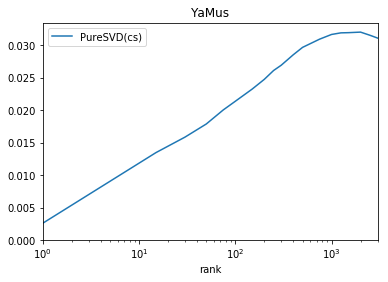

In [31]:
report_results('rank', scores_cold);

In [32]:
config_cold

{'YaMus': {'PureSVD(cs)': {'rank': 2000}}}

### saving data

In [33]:
save_results(experiment_name+'_coldstart', config=config_cold, tuning=scores_cold)

## cross validation

In [34]:
result_cold = {}
for label in track(data_labels):
    models_cold = prepare_cold_start_recommender_models(label, data_models_cold, config_cold)
    result_cold[label] = ee.run_cv_experiment(models_cold,
                                              fold_experiment=ee.topk_test,
                                              topk_list=topk_values,
                                              ignore_feedback=True,
                                              iterator=lambda x: track(x, label=f'{label} folds'))

 [████████████████████████████████████████████████████████████] 1/1 [03:23:56<03:23:56, 12236.25s/it]

    YaMus folds [█████████████████████████████████████████████] 5/5 [03:23:56<40:47, 2447.25s/it]

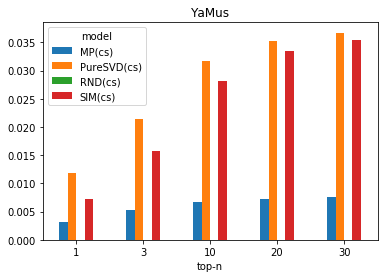

In [35]:
report_results('topn', result_cold, target_metric);

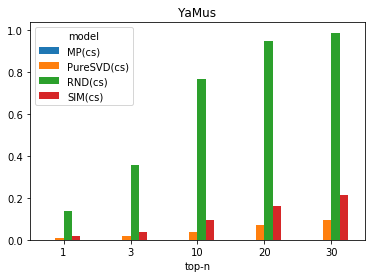

In [36]:
report_results('topn', result_cold, 'coverage');

### saving data

In [37]:
save_results(experiment_name+'_coldstart', cv=result_cold)